### Use SHAP to examine how parameters influence prediction

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import os

if "notebooks" in os.getcwd():
    os.chdir("..")

shap.initjs()

### Load model

In [2]:
# Load the model
# Keras needs to know about the custom metric
def pct_positive_cases(y_true, y_pred):
    return tf.math.reduce_mean(y_true)

model = keras.models.load_model(
    "data_working/models/preisler_classif_noyear.model", 
    custom_objects={"pct_positive_cases": pct_positive_cases}
)

In [3]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 fire (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 near (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 latitude (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 longitude (InputLayer)         [(None, 1)]          0           []                               
                                                                                            

### Load background data

In [4]:
from google.cloud.storage import Client

client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="preisler-rectangular")
    if f.name.endswith("csv")
]

ds = pd.concat((pd.read_csv(f).drop(["system:index", ".geo"], axis=1) for f in records), ignore_index=True)
bg = ds.sample(n=1000)

In [5]:
bg.head()

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
145026,0.0,40.000397,-122.907497,0.0116,0.0768,828.328233,967.481583,674.871316,1896.617786,0.833323,-8.906769,2010
264453,0.0,40.439389,-121.362395,0.3820,0.4784,885.420161,724.297144,1027.981900,899.097406,0.512456,-16.053814,2016
289251,0.0,41.899922,-120.212551,0.6128,0.1612,810.750543,605.945443,483.613666,599.500525,0.788563,-20.743816,2017
215460,0.0,37.135424,-121.937317,0.0068,0.0096,739.978515,685.675841,1199.502137,970.259615,0.089555,-3.477944,2014
311302,0.0,37.364244,-119.457966,0.6652,0.2232,862.583287,2473.407669,1544.012995,703.827548,0.773910,-13.851316,2019


In [6]:
submodel = keras.models.Model(
    model.get_layer("concatenate_2").output,
    model.get_layer("mortality").output
)

In [7]:
submodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 batch_normalization_5 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 128)               1408      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 16)                2064      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                             

In [8]:
# Verify that the predictions are possible and reasonable
target = "pct_mortality"
bands  = ["fire", "near", "latitude", "longitude", "prcp1", "prcp2", "prcp3", "prcp4", "rhost", "winter_tmin"]
y = bg[target].to_numpy()
X = bg[bands].to_numpy()

In [9]:
y_hat = submodel.predict(X).squeeze()

32/32 [==============================] - 0s 987us/step


In [10]:
m = keras.metrics.AUC()
m.update_state(y > 0, y_hat)
m.result().numpy()

0.8445504

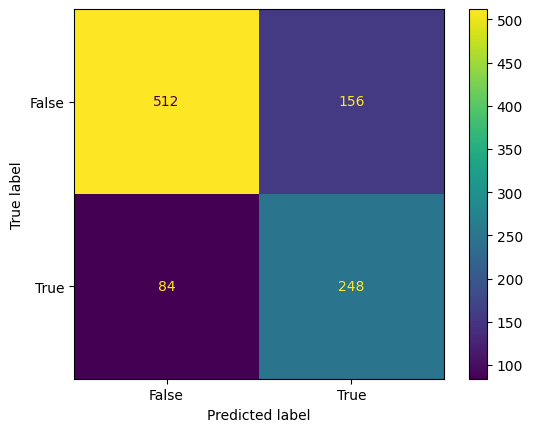

In [15]:
ConfusionMatrixDisplay.from_predictions(y > 0, y_hat > 0.33)
plt.show()

Looks good!

### Run an explainer

In [12]:
def eval(X):
    return submodel.predict(X).flatten()

explainer = shap.DeepExplainer(submodel, X)
explanation = explainer(X)

C:\Users\rsgal\miniconda3\envs\gee\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\rsgal\miniconda3\envs\gee\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [13]:
explanation.values = np.squeeze(explanation.values)
explanation.feature_names = bands

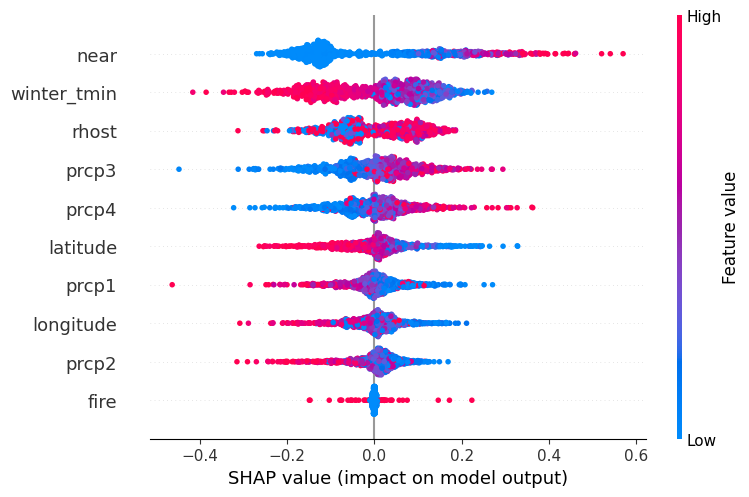

In [14]:
shap.plots.beeswarm(explanation)